# Import important libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [5]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/Stock Trade Prediction/BAJFINANCE.csv')
df['date'] = pd.to_datetime(df['Date'])
df

<ipython-input-5-cceac20cf099>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['Date'])


,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,date
0,20-02-2017,1092.95,1109.50,1035.00,1095.90,1095.90,617565,-0.229510,-1106,4819,2017-02-20
1,21-02-2017,1092.20,1105.95,1085.00,1095.90,1095.90,335482,-0.170780,-339,1985,2017-02-21
2,22-02-2017,1095.00,1104.15,1065.00,1076.25,1076.25,1000632,-0.177740,-214,1204,2017-02-22
3,23-02-2017,1083.00,1099.00,1066.50,1068.20,1068.20,1196177,-0.200510,-237,1182,2017-02-23
4,27-02-2017,1070.85,1104.00,1069.00,1091.60,1091.60,1223440,-0.175170,-230,1313,2017-02-27
...,...,...,...,...,...,...,...,...,...,...,...
1032,26-04-2021,4690.00,4829.00,4690.00,4736.55,4736.55,2903989,-0.050980,-13,255,2021-04-26
1033,27-04-2021,4747.00,4889.85,4746.55,4865.05,4865.05,2644997,-0.036424,-11,302,2021-04-27
1034,28-04-2021,4915.00,5310.00,4915.00,5280.90,5280.90,8576454,-0.066351,-14,211,2021-04-28
1035,29-04-2021,5350.00,5525.00,5330.00,5484.85,5484.85,7258486,-0.051282,-8,156,2021-04-29


## Understanding the time Series

<Axes: xlabel='date', ylabel='Adj Close'>

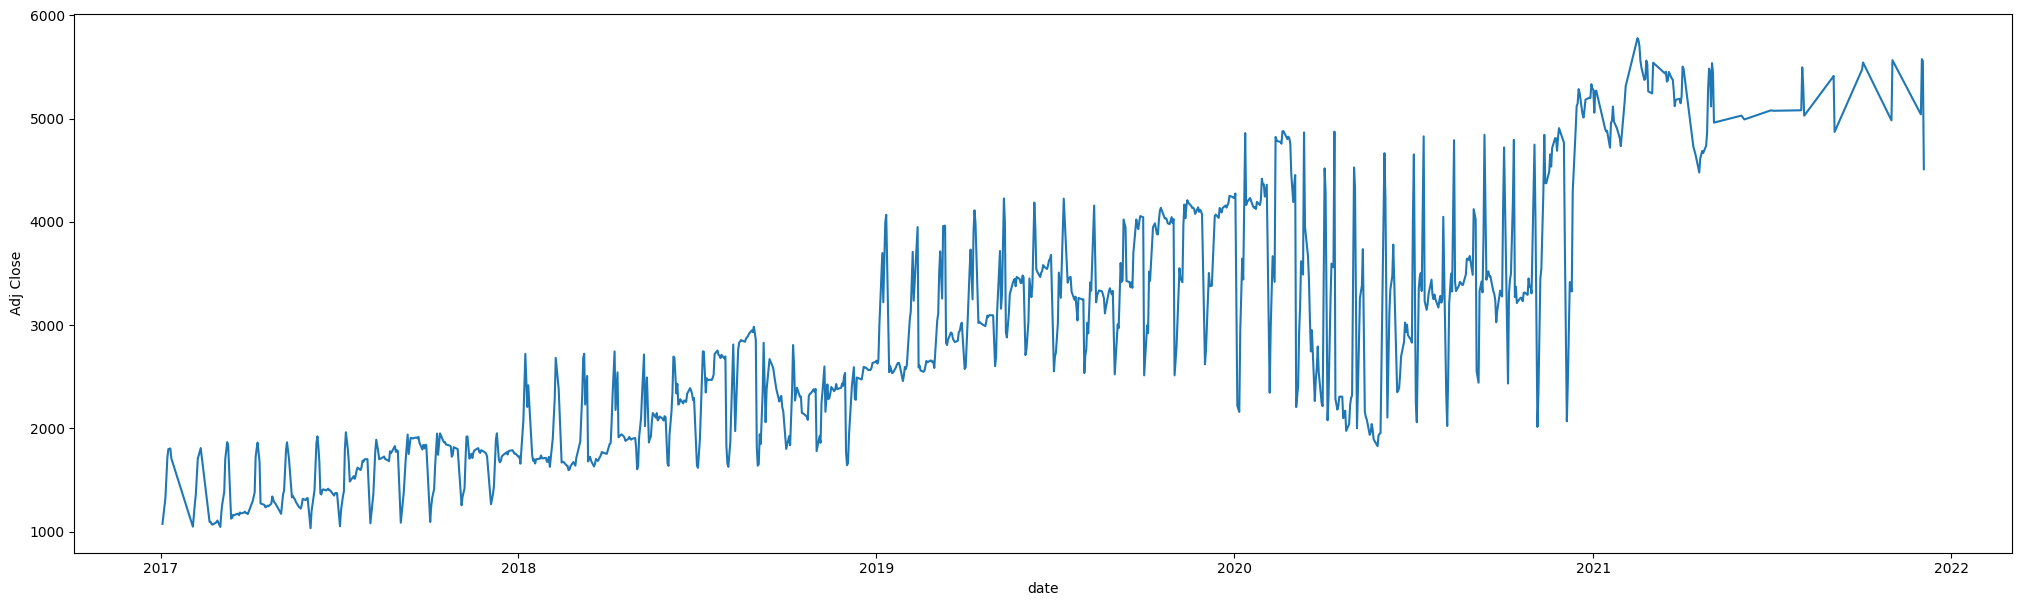

In [7]:
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])

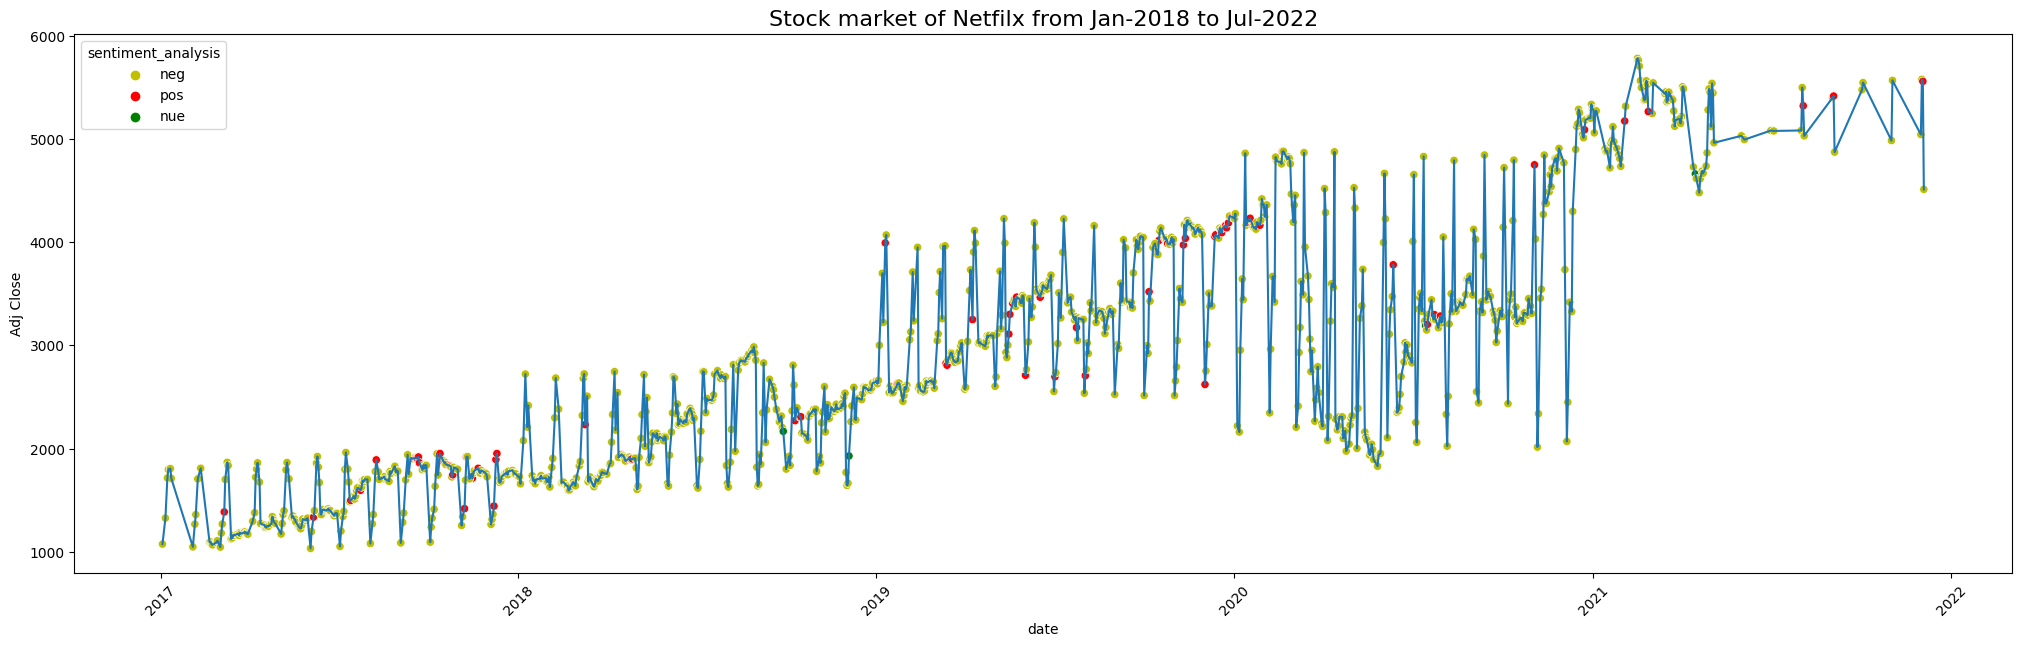

In [6]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [8]:
df['sentiment_analysis'].value_counts()

neg    955
pos     76
nue      6
Name: sentiment_analysis, dtype: int64

In [9]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,date,sentiment_analysis
14,14-03-2017,1112.0,1135.45,1103.40,1126.70,1126.70,1254682,-0.210030,-155,738,2017-03-14,neg
15,15-03-2017,1129.0,1143.20,1124.25,1134.55,1134.55,781510,-0.150400,-94,625,2017-03-15,neg
16,16-03-2017,1139.7,1178.00,1130.85,1163.50,1163.50,1234503,-0.121700,-60,493,2017-03-16,neg
17,17-03-2017,1170.0,1183.70,1151.30,1159.30,1159.30,822826,-0.076580,-51,666,2017-03-17,neg
18,20-03-2017,1165.0,1192.30,1142.75,1172.55,1172.55,978371,-0.158540,-91,574,2017-03-20,neg
...,...,...,...,...,...,...,...,...,...,...,...,...
1032,26-04-2021,4690.0,4829.00,4690.00,4736.55,4736.55,2903989,-0.050980,-13,255,2021-04-26,neg
1033,27-04-2021,4747.0,4889.85,4746.55,4865.05,4865.05,2644997,-0.036424,-11,302,2021-04-27,neg
1034,28-04-2021,4915.0,5310.00,4915.00,5280.90,5280.90,8576454,-0.066351,-14,211,2021-04-28,neg
1035,29-04-2021,5350.0,5525.00,5330.00,5484.85,5484.85,7258486,-0.051282,-8,156,2021-04-29,neg


In [10]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2017-03-14,1112.0,1135.45,1103.40,1126.70,1254682.0,1126.70,-0.210030
2017-03-15,1129.0,1143.20,1124.25,1134.55,781510.0,1134.55,-0.150400
2017-03-16,1139.7,1178.00,1130.85,1163.50,1234503.0,1163.50,-0.121700
2017-03-17,1170.0,1183.70,1151.30,1159.30,822826.0,1159.30,-0.076580
2017-03-20,1165.0,1192.30,1142.75,1172.55,978371.0,1172.55,-0.158540
...,...,...,...,...,...,...,...
2021-04-26,4690.0,4829.00,4690.00,4736.55,2903989.0,4736.55,-0.050980
2021-04-27,4747.0,4889.85,4746.55,4865.05,2644997.0,4865.05,-0.036424
2021-04-28,4915.0,5310.00,4915.00,5280.90,8576454.0,5280.90,-0.066351


# LSTM Model

## Data scaling for LSTM because uses sigmoid and tanh that are sensitive to magnitude

In [11]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.        , 0.        , 0.        , ..., 0.0427997 , 0.        ,
        0.14394747],
       [0.00363294, 0.0016536 , 0.00454555, ..., 0.02446687, 0.00168703,
        0.3226437 ],
       [0.00591956, 0.00907879, 0.00598443, ..., 0.04201787, 0.00790862,
        0.40865045],
       ...,
       [0.81271103, 0.89071318, 0.83097517, ..., 0.3264784 , 0.89277156,
        0.57451846],
       [0.90567167, 0.93658719, 0.92145022, ..., 0.27541434, 0.93660209,
        0.61967548],
       [0.90567167, 0.93651251, 0.92094879, ..., 0.15400452, 0.92952086,
        0.51735117]])

## As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.

In [12]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1018, 5, 7).
TrainY shape = (1018, 1, 2).


## Train test split for LSTM

In [13]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((814, 5, 6), (814, 5, 7))

## Train validation split for LSTM

In [14]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((732, 5, 6), (732, 5, 7))

## Model architecture

In [15]:
from tensorflow.keras.layers import LSTM

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split

# build the model
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))
    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

# fit the model
cnn_lstm_model_without_twitter = build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter = build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1)

history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

## Plotting Training and validation loss

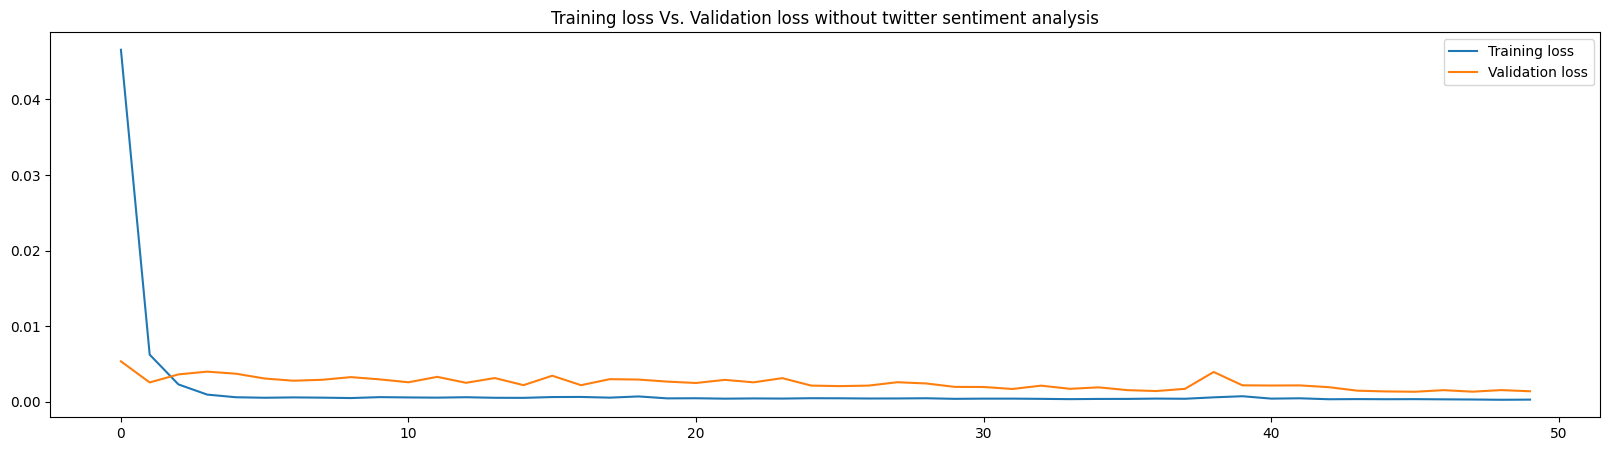

In [17]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()


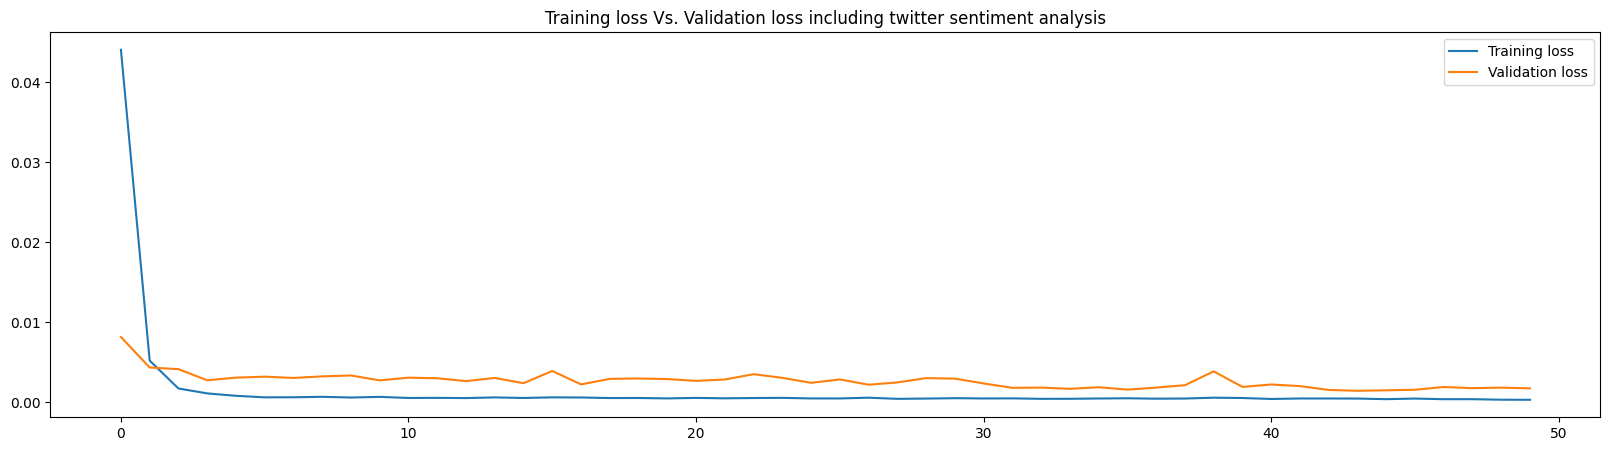

In [18]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

## Plotting

In [19]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

# Computing training accuracy

In [20]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)



23/23 [==============================] - 2s 9ms/step


####  Training accuracy without twitter

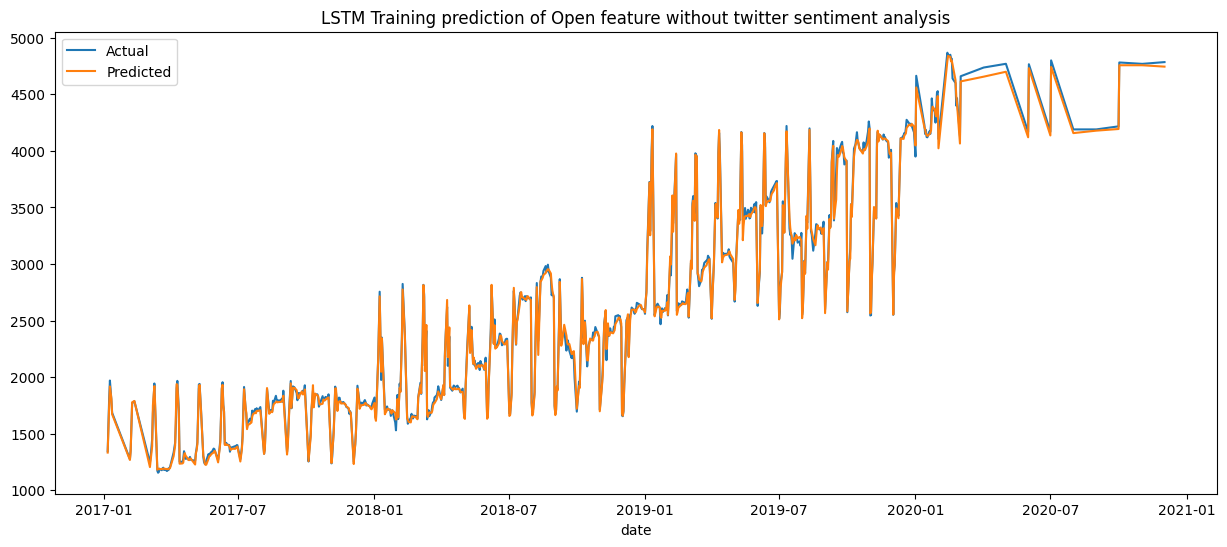

Mean square error for Open =1525.4465043059868


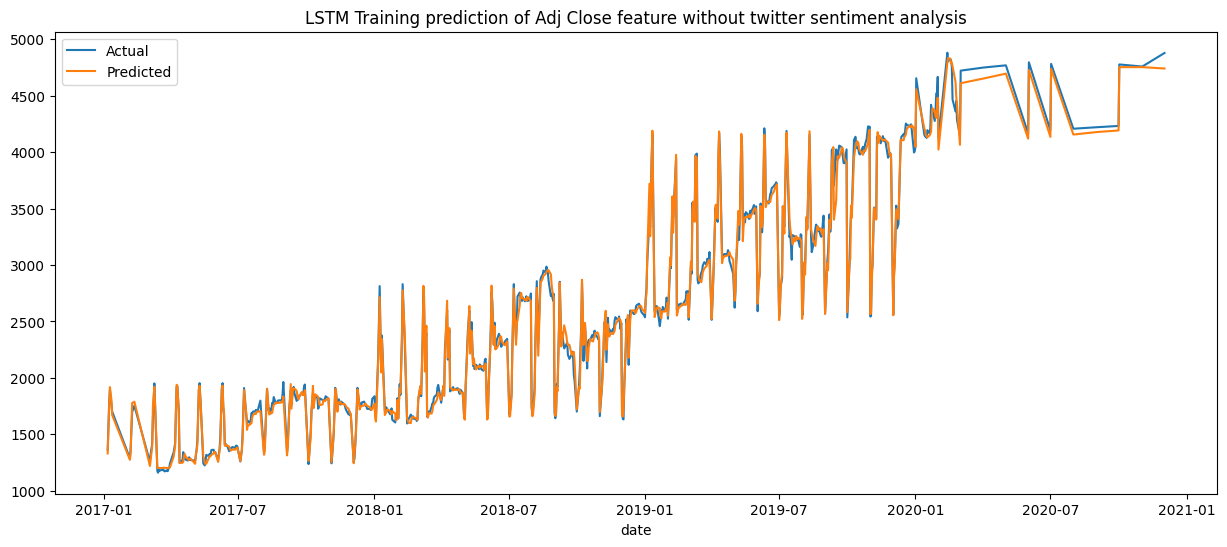

Mean square error for Adj Close =4040.579071245565
Total mean square error 2783.0127877757777


In [21]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

#### Training accuracy after adding the impact of twitter sentiment analysis

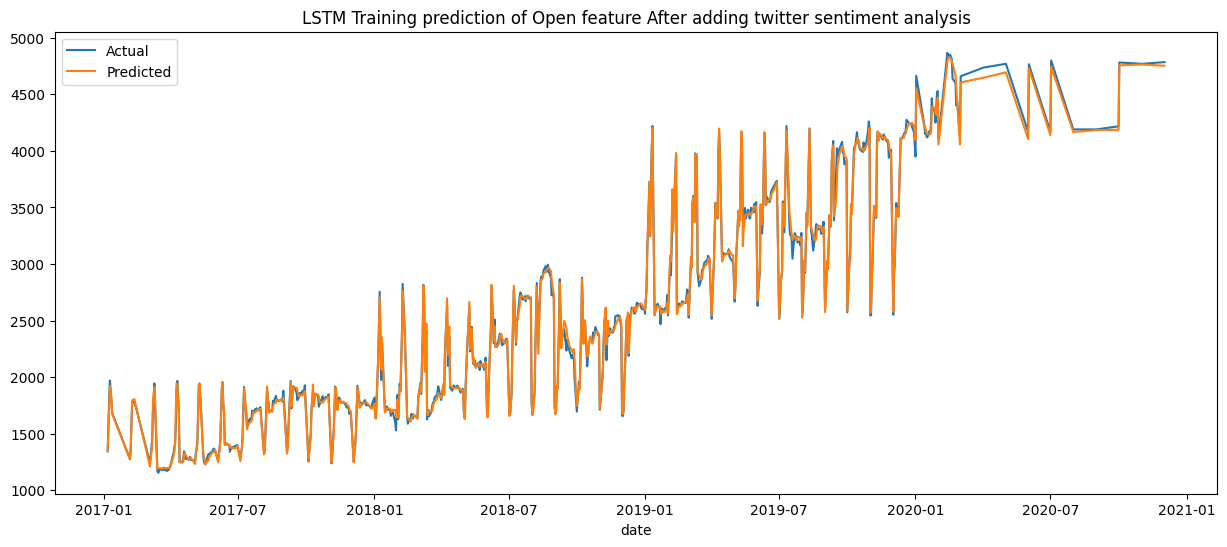

Mean square error for Open =2118.850399445999


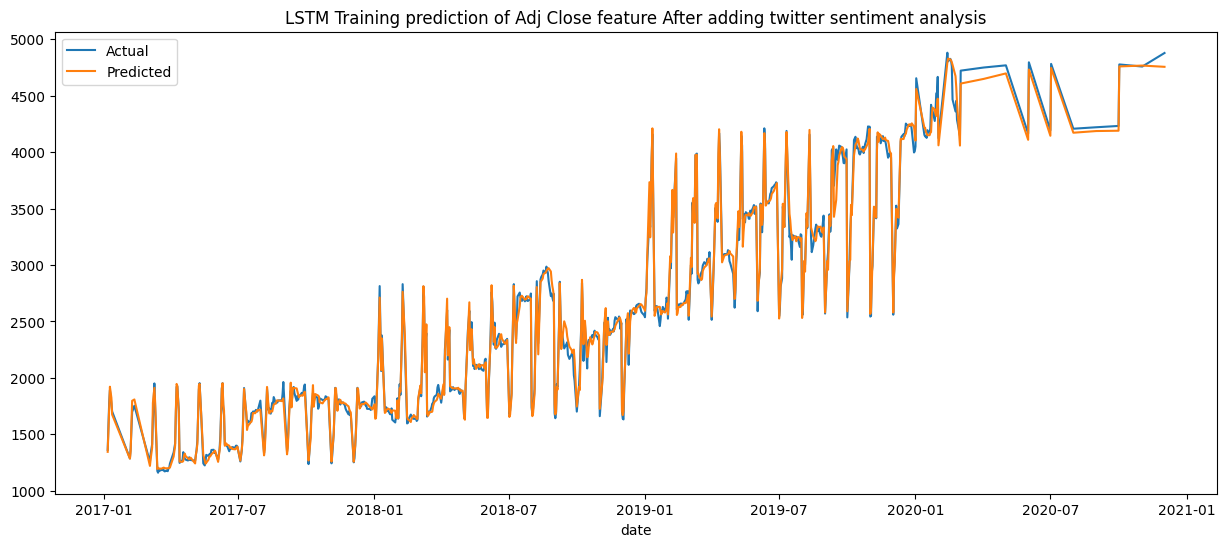

Mean square error for Adj Close =4598.098733527359
Total mean square error 3358.474566486676


In [22]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

## Computing validation accuracy

In [23]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)



3/3 [==============================] - 0s 10ms/step


#### Validation accuracy without twitter

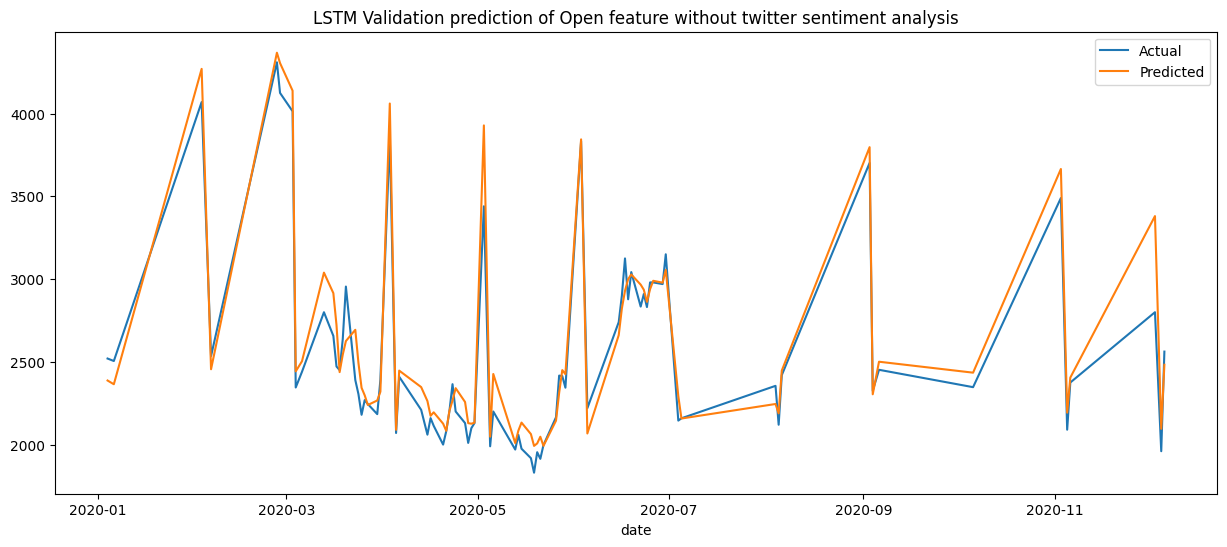

Mean square error for Open =21910.60227728635


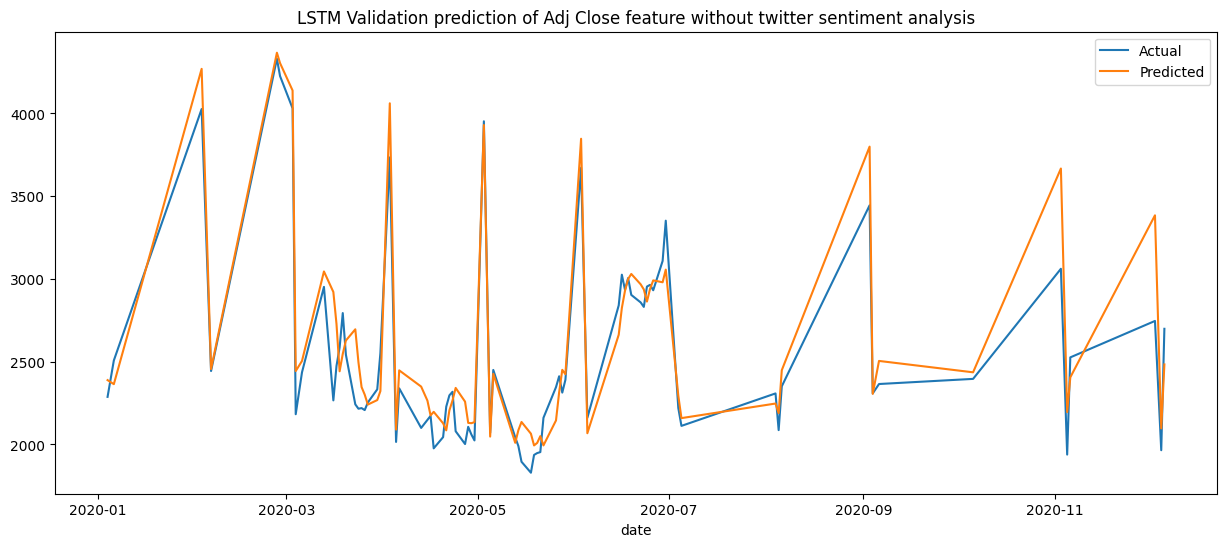

Mean square error for Adj Close =38791.24517719105
Total mean square error 30350.9237272387


In [24]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

#### Validation accuracy after adding the impact of twitter sentiment analysis

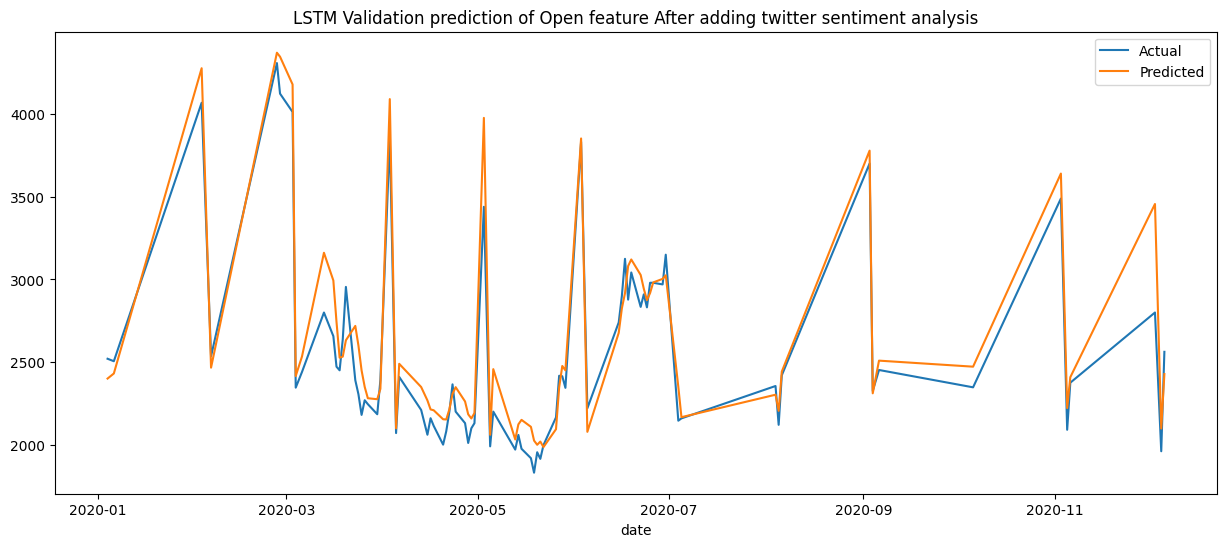

Mean square error for Open =29453.625609074606


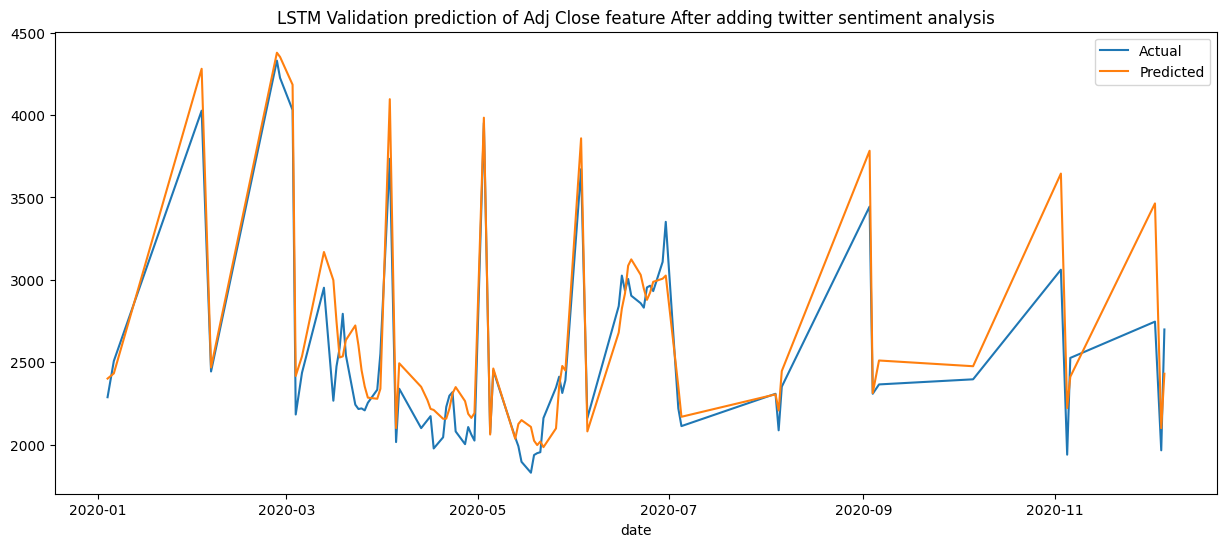

Mean square error for Adj Close =46305.34591634683
Total mean square error 37879.48576271071


In [25]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)

## Computing testing accuracy

In [26]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)



7/7 [==============================] - 0s 10ms/step


#### Testing accuracy without twitter

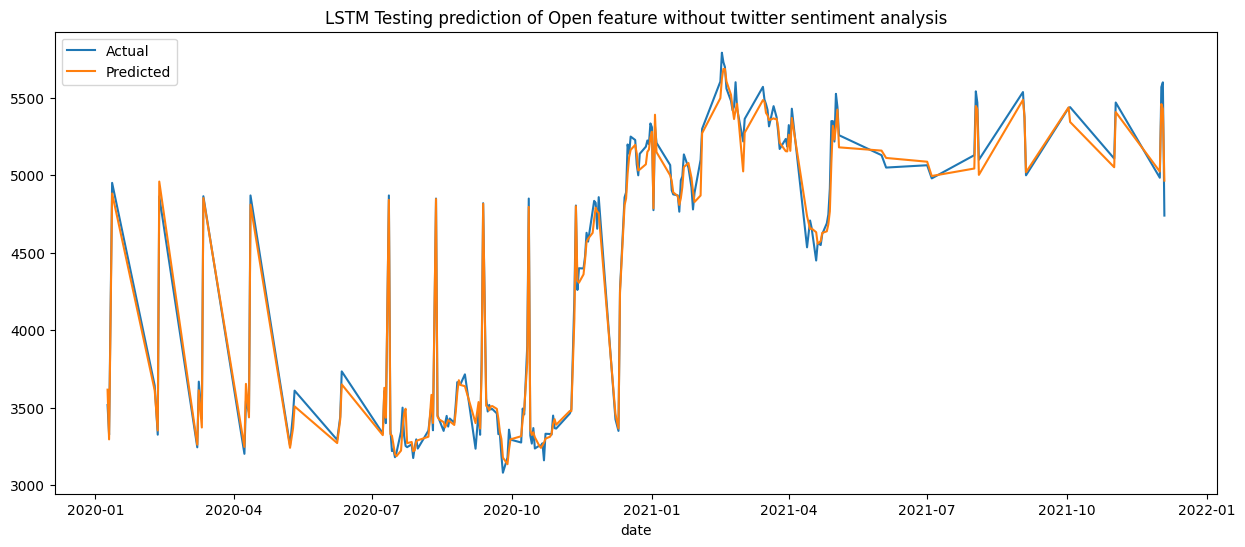

Mean square error for Open =6128.063870926186


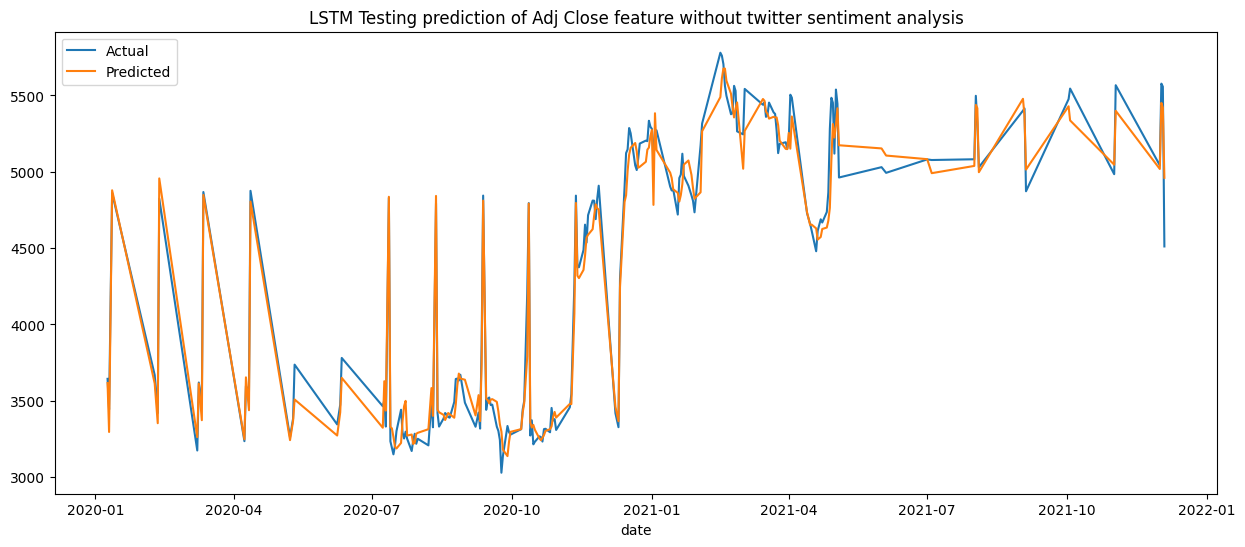

Mean square error for Adj Close =17010.320006250622
Total mean square error 11569.191938588407


In [27]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

#### Testing accuracy after adding the impact of twitter sentiment analysis

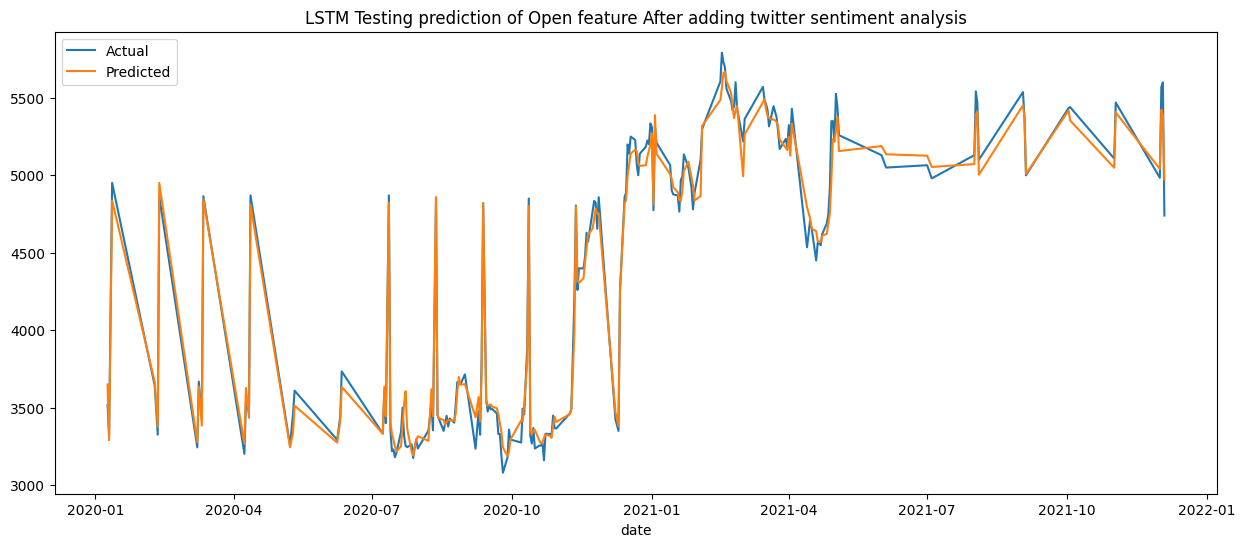

Mean square error for Open =9167.594298504686


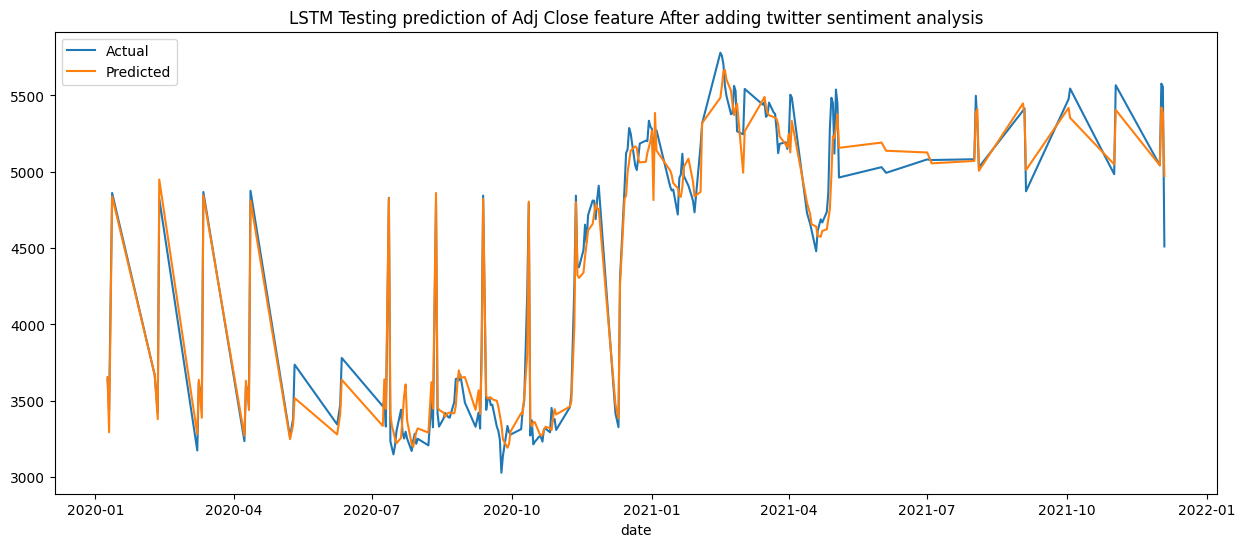

Mean square error for Adj Close =19686.586780822323
Total mean square error 14427.090539663503


In [28]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

# Forcasting for upcoming data

In [29]:
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past_dates = 5
n_days_for_prediction = 5 #let us predict past 15 days

predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2021-04-26 00:00:00', freq='C'), Timestamp('2021-04-27 00:00:00', freq='C'), Timestamp('2021-04-28 00:00:00', freq='C'), Timestamp('2021-04-29 00:00:00', freq='C'), Timestamp('2021-04-30 00:00:00', freq='C')]


In [30]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

## Make forcasting using LSTM

In [31]:
x_forcast=df_for_training.iloc[-n_past-1:-1,:]
x_forcast=scaler.transform(x_forcast).reshape(1,n_past,len(features))
prediction = cnn_lstm_model_twitter.predict(x_forcast) #shape = (n, 1) where n is the n_days_for_prediction
prediction=prediction.reshape(prediction.shape[0],prediction.shape[2])
#Perform inverse transformation to rescale back to original range
prediction=scaler_for_inference.inverse_transform(prediction)

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {prediction[0][0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {prediction[0][1]}')

1/1 [==============================] - 0s 32ms/step
Date = 2021-04-29, Prediction open 5234.20263671875
Date = 2021-04-29, Prediction Adjusted close 5233.55712890625


### Actual forcasting in 2022-07-07 are  open 184.27     adjusted close 189.27